# [DM 2025/26] Phoneme Classification

In [ ]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities
import csv
import json
import os

## Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

## Preprocessing
from sklearn.preprocessing import MinMaxScaler, Binarizer

## 0. Utilities

In [2]:
def save_csv_dataset(data: pd.DataFrame, save_name: str):
    
    if not save_name.endswith('.csv'):
        save_name += '.csv'
    
    data.to_csv(save_name, index=False, encoding='utf-8')
    abs_path = os.path.abspath(save_name)
    
    print(f"Dataset salvato in: {abs_path}")
    print(f"Righe: {len(data)}, Colonne: {len(data.columns)}")
    
    return abs_path

## 1. Dataset Analysis

In [2]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data
labels = dataset.target

# Taking feature names and label names
feature_names = dataset.feature_names
label_counts = np.unique_counts(labels)

In [3]:
data.head()

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127


In [4]:
labels.value_counts()

Class
1    3818
2    1586
Name: count, dtype: int64

In [5]:
# Extracting statistics on data
data.describe()

,V1,V2,V3,V4,V5
count,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03
mean,3.330866e-09,5.551443e-09,6.106588e-09,-9.437454e-09,-6.698742e-08
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.933743e+00,-3.038709e+00,-2.795869e+00,-2.485340e+00,-2.367461e+00
25%,-6.697555e-01,-7.790800e-01,-9.505788e-01,-7.583255e-01,-5.405418e-01
50%,-3.801605e-01,-2.150985e-01,-3.861800e-02,-1.422555e-01,-2.127475e-01
75%,3.149040e-01,7.136990e-01,7.771393e-01,6.759035e-01,2.045420e-01
max,3.828575e+00,3.664763e+00,2.630868e+00,3.046948e+00,4.586666e+00


From the statistical report we notice that all the features have mean equal to zero and standard deviation equal to 1, so they are already standard scaled.

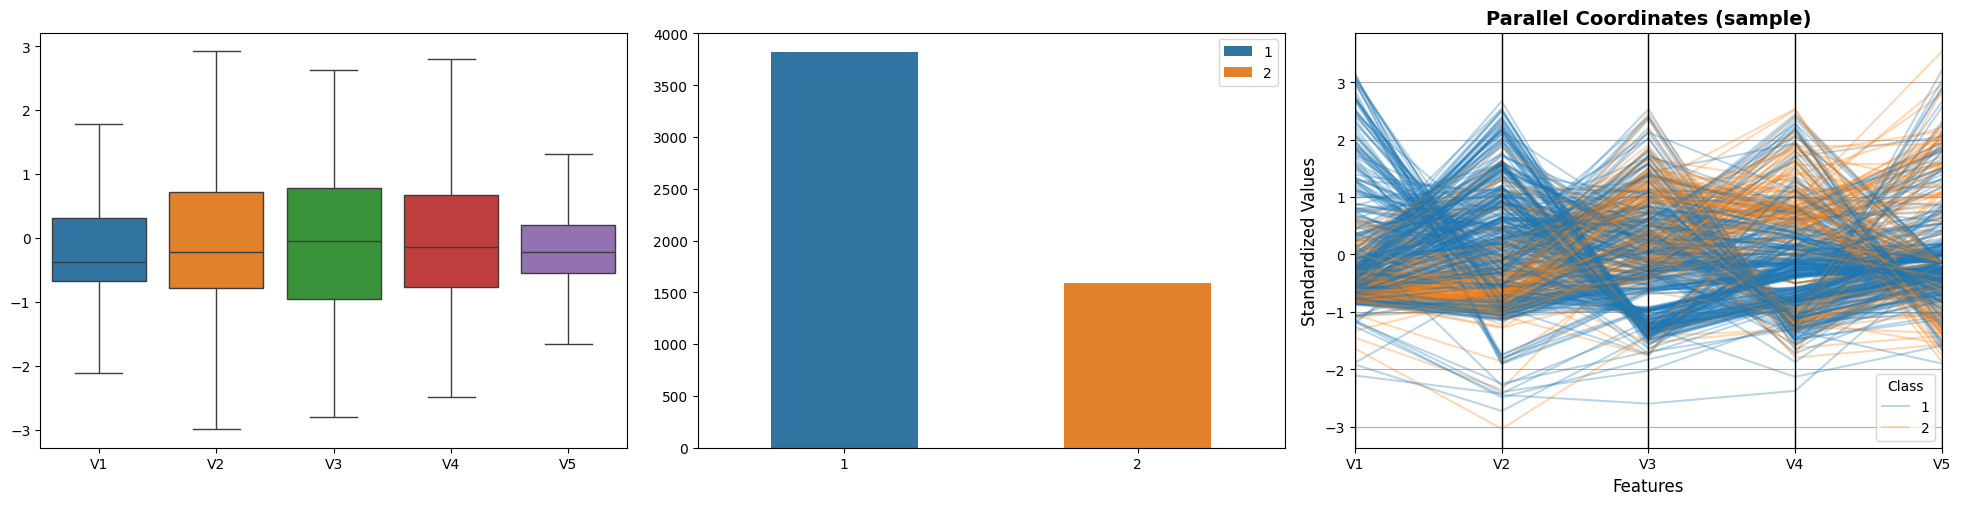

In [7]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Campiona per rendere il grafico leggibile
df_sample = df.sample(n=min(500, len(df)), random_state=42)

parallel_coordinates(
    frame=df_sample,  # Usa campione
    class_column="class",
    color=sns.color_palette("tab10", n_colors=2),
    ax=axs[2],
    alpha=0.3  # Trasparenza per vedere meglio
)
axs[2].set_title("Parallel Coordinates (sample)", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Features", fontsize=12)
axs[2].set_ylabel("Standardized Values", fontsize=12)
axs[2].legend(title='Class', loc='best')
plt.show()

The class distribution shows that the two classes are highly imbalanced with class 1 being represented for more than twice class 2, this suggests need for future preprocessing aimed to balance the class frequency.

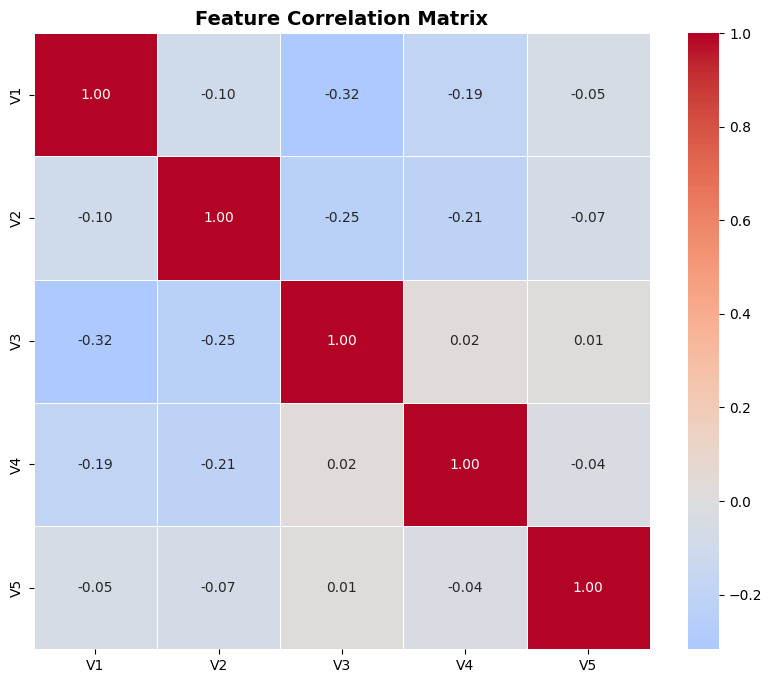

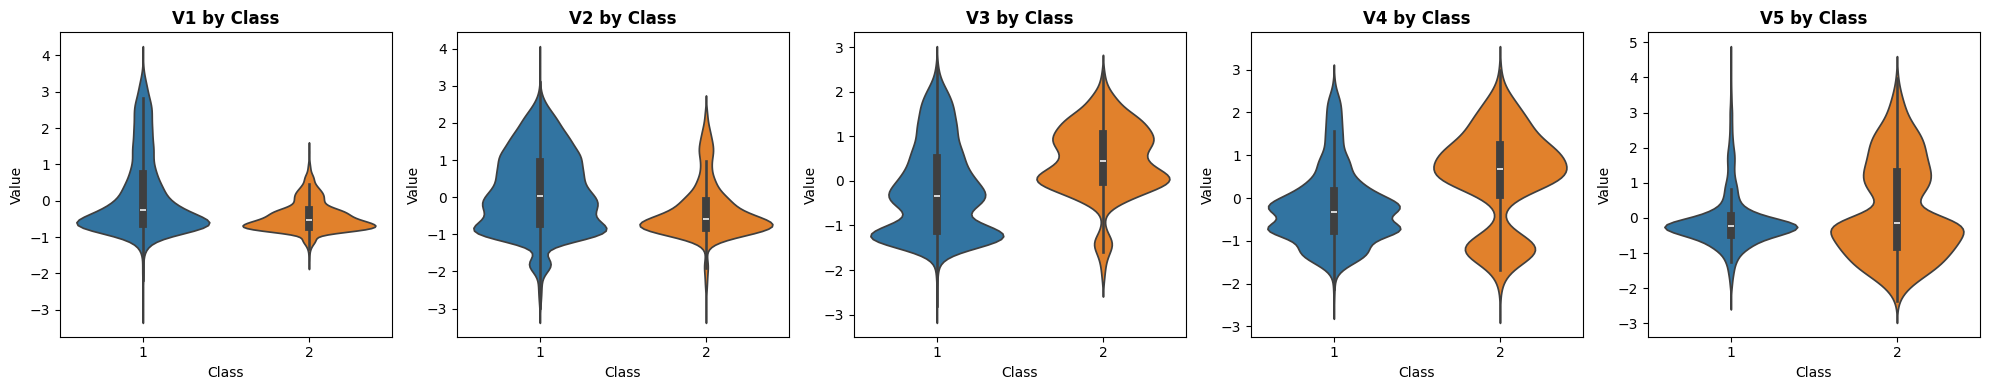

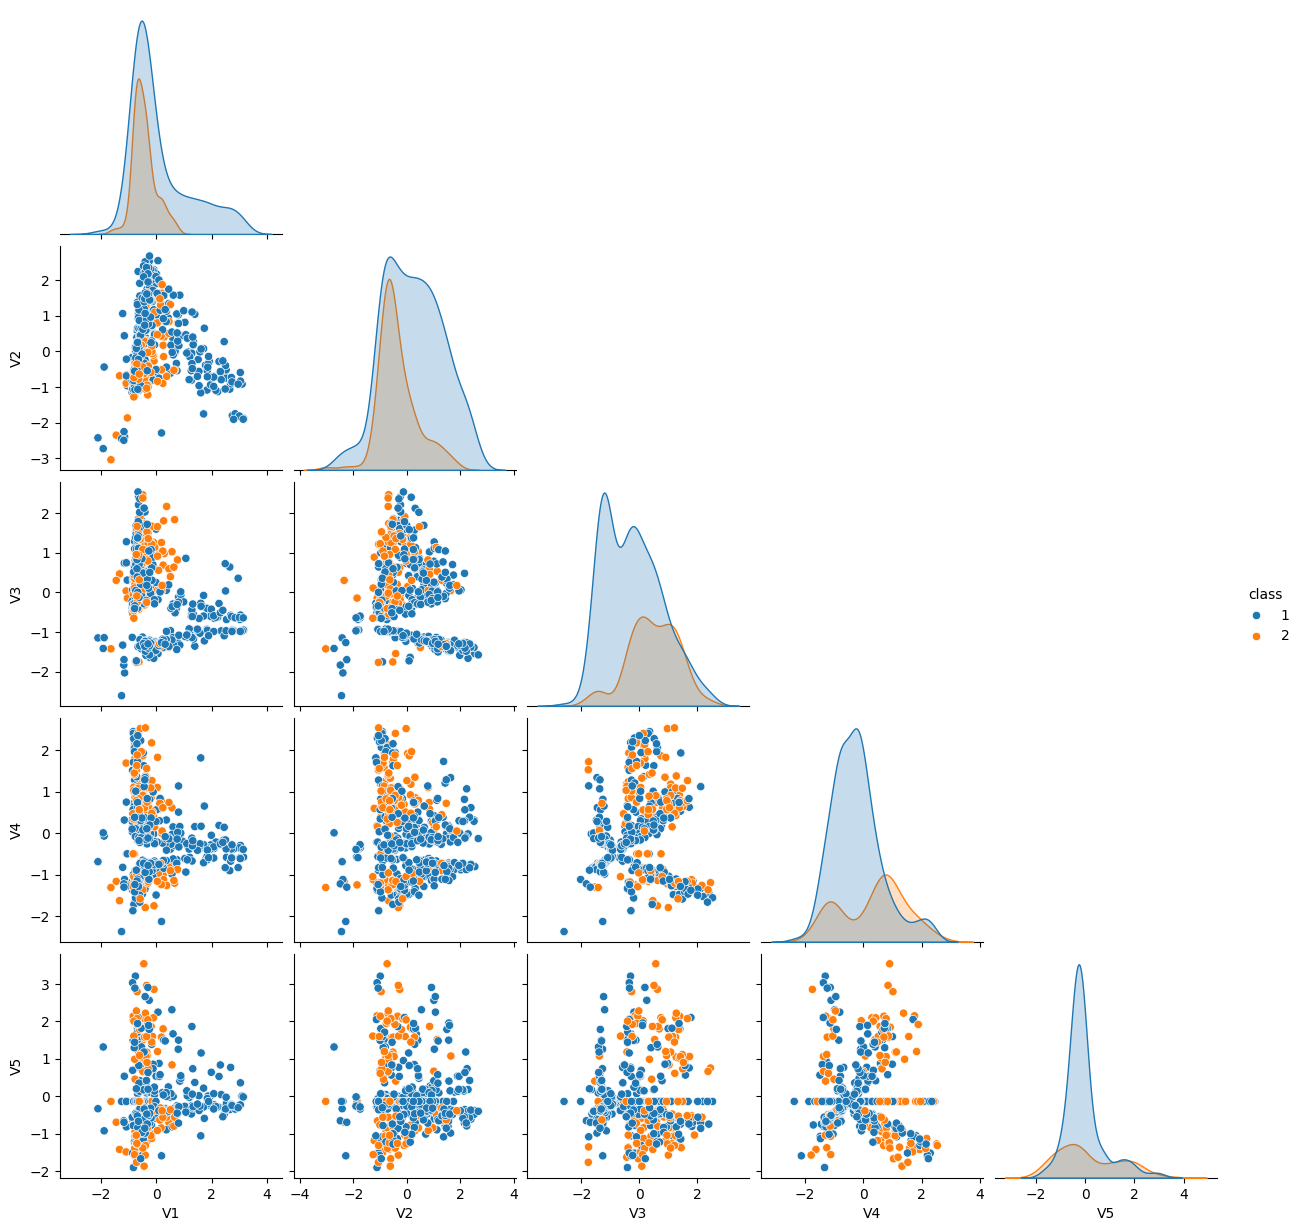

In [8]:
#  CORRELAZIONE TRA FEATURES
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

# DISTRIBUZIONE PER CLASSE (violin plot)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, col in enumerate(data.columns):
    df_plot = data.copy()
    df_plot['class'] = labels
    sns.violinplot(data=df_plot, 
                   x='class', 
                   y=col, 
                   hue='class',  
                   palette='tab10', 
                   legend=False,  
                   ax=axes[idx])
    axes[idx].set_title(f'{col} by Class', fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Value')
plt.tight_layout()
plt.show()

#PAIRPLOT 
df_sample = data.sample(n=500, random_state=42).copy()
df_sample['class'] = labels[df_sample.index]
sns.pairplot(df_sample, hue='class', palette='tab10', diag_kind='kde', corner=True)
plt.show()

## 2. Preprocessing

In [8]:
# Preprocessing variables
RANDOM_SEED = 42
TRAIN_SIZE = 0.75

### 2.1 Missing values handling

In [12]:
data.isna().describe()

,V1,V2,V3,V4,V5
count,5404,5404,5404,5404,5404
unique,1,1,1,1,1
top,False,False,False,False,False
freq,5404,5404,5404,5404,5404


### 2.2 Train-Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4053, 5), (1351, 5), (4053,), (1351,))

In [14]:
X_train.to_csv("data/X_train.csv", sep=",", index=False)
X_test.to_csv("data/X_test.csv", sep=",", index=False)
y_train.to_csv("data/y_train.csv", sep=",", index=False)
y_test.to_csv("data/y_test.csv", sep=",", index=False)

### 2.3 Balancing

In [15]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
y_train_under[y_train_under=="1"].shape, y_train_under[y_train_under=="2"].shape

((1196,), (1196,))

In [16]:
X_train_under.to_csv("data/X_train_under.csv", sep=",", index=False)
y_train_under.to_csv("data/y_train_under.csv", sep=",", index=False)

In [17]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
y_train_over[y_train_over=="1"].shape, y_train_over[y_train_over=="2"].shape

((2857,), (2960,))

In [18]:
X_train_over.to_csv("data/X_train_over.csv", sep=",", index=False)
y_train_over.to_csv("data/y_train_over.csv", sep=",", index=False)

### 2.3 Reduction

#### 2.3.1 PCA reduction

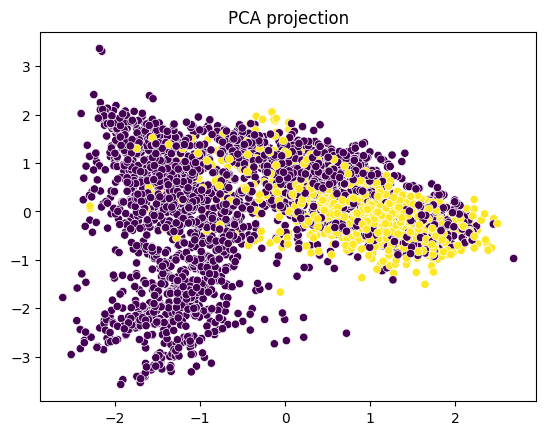

((4053, 2), (1351, 2))

In [17]:
from sklearn.decomposition import PCA

pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

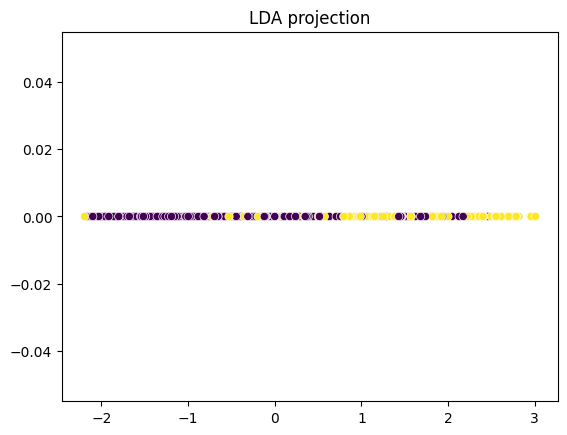

((4053, 1), (1351, 1))

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

over sampling 

## 3. Classification

In [32]:
# models = {
#     "DecisionTree": {
#         "instance": DecisionTreeClassifier(random_state=RANDOM_SEED),
# 	},
#     "NaiveBayes": {
#         "instance": GaussianNB(),
# 	},
#     "KNN": {
#         "instance": KNeighborsClassifier(),
# 	},
# 	"SVC": {
# 		"instance": SVC(random_state=RANDOM_SEED),
# 	},
#     "MLP": {
#         "instance": MLPClassifier(random_state=RANDOM_SEED),
# 	},
#     "RandomForest": {
#         "instance": RandomForestClassifier(random_state=RANDOM_SEED),
# 	},
#     "AdaBoost": {
#         "instance": AdaBoostClassifier(random_state=RANDOM_SEED),
# 	},
#     "XGBoost": {
#         "instance": XGBClassifier(),
# 	}
# }


models_base = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=RANDOM_SEED),
    "MLP": MLPClassifier(random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_SEED),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(),
}

import copy
models = {
    name: {
        sampling: copy.deepcopy(model) 
        for sampling in ["over", "under", "none"]
    } 
    for name, model in models_base.items()
}

In [33]:
# Importing the file of the tuned iperparameters
with open("./tuned_hyperparameters.json", mode="r") as file:
	hyperparameters = json.load(file)



for model in models.keys():
	for sampling in ("over", "under", "none"):
		models.get(model).get(sampling).set_params(**hyperparameters.get(sampling).get(model).get("params"))
		print(f"{model}-{sampling}: {models.get(model).get(sampling).get_params()}")

print(type(models))

DecisionTree-over: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-under: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-none: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 24, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
NaiveBayes-over: {'priors': None, 'va

### 3.1 Shallow Machine Learning

#### 3.1.1 Decision Tree

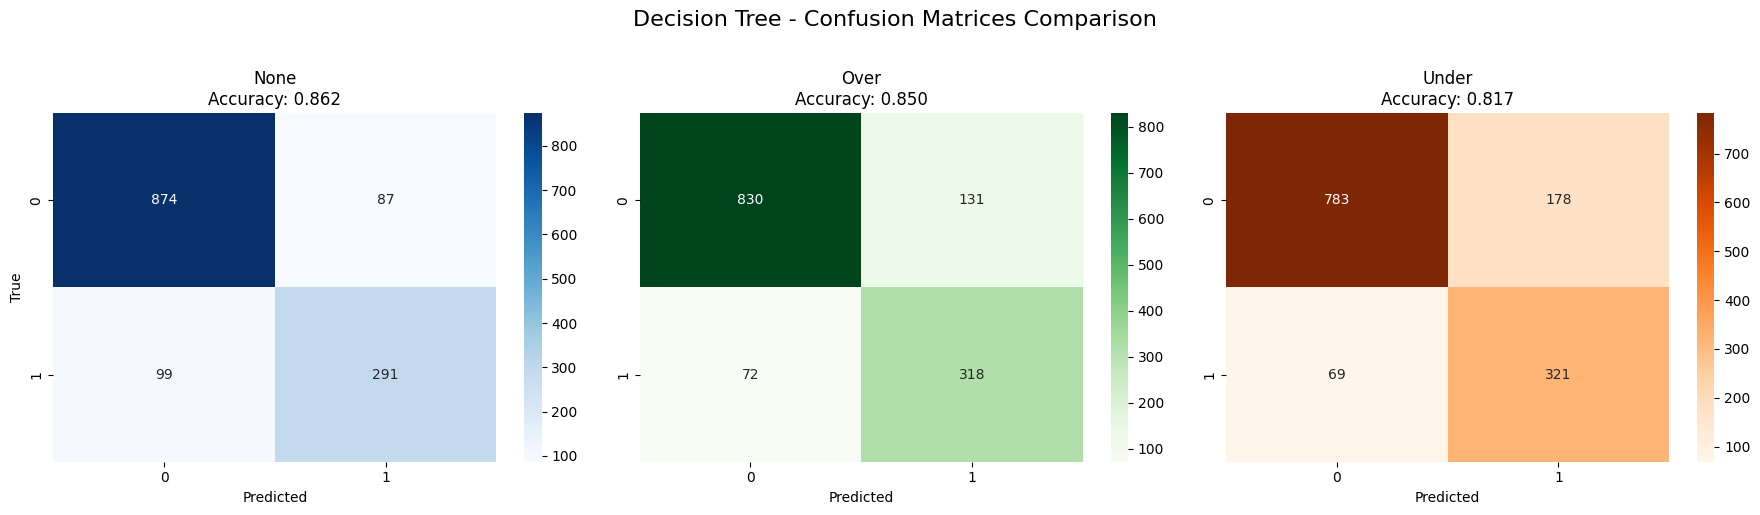


DECISION TREE - STRATEGY: NONE
Accuracy: 0.8623

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.91      0.90       961
           2       0.77      0.75      0.76       390

    accuracy                           0.86      1351
   macro avg       0.83      0.83      0.83      1351
weighted avg       0.86      0.86      0.86      1351


DECISION TREE - STRATEGY: OVER
Accuracy: 0.8497

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.86      0.89       961
           2       0.71      0.82      0.76       390

    accuracy                           0.85      1351
   macro avg       0.81      0.84      0.82      1351
weighted avg       0.86      0.85      0.85      1351


DECISION TREE - STRATEGY: UNDER
Accuracy: 0.8172

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.81      0.86       961
           2     

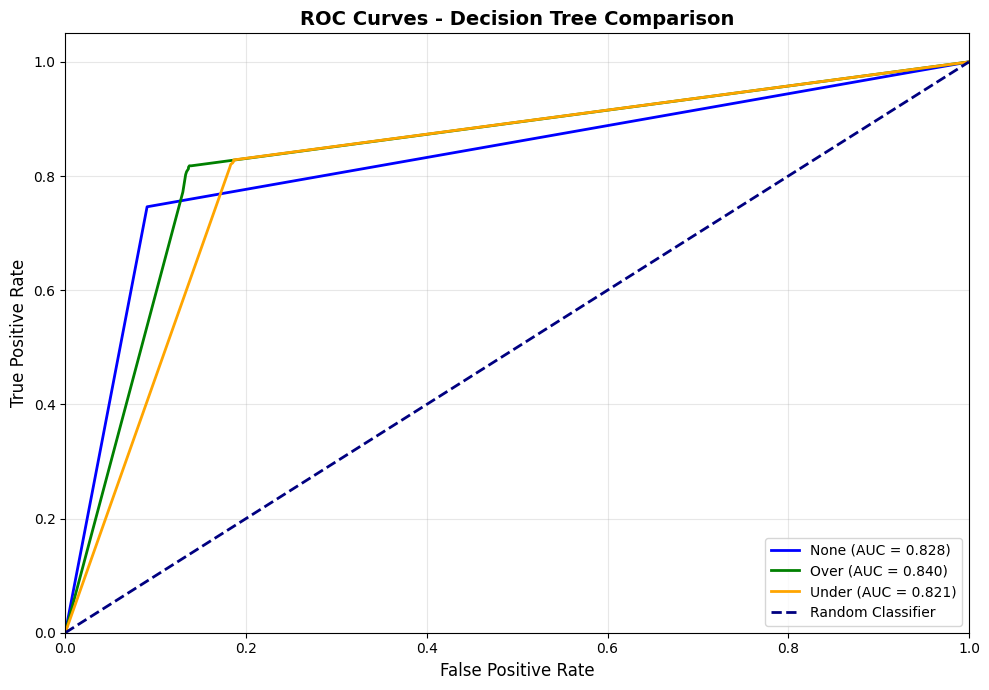

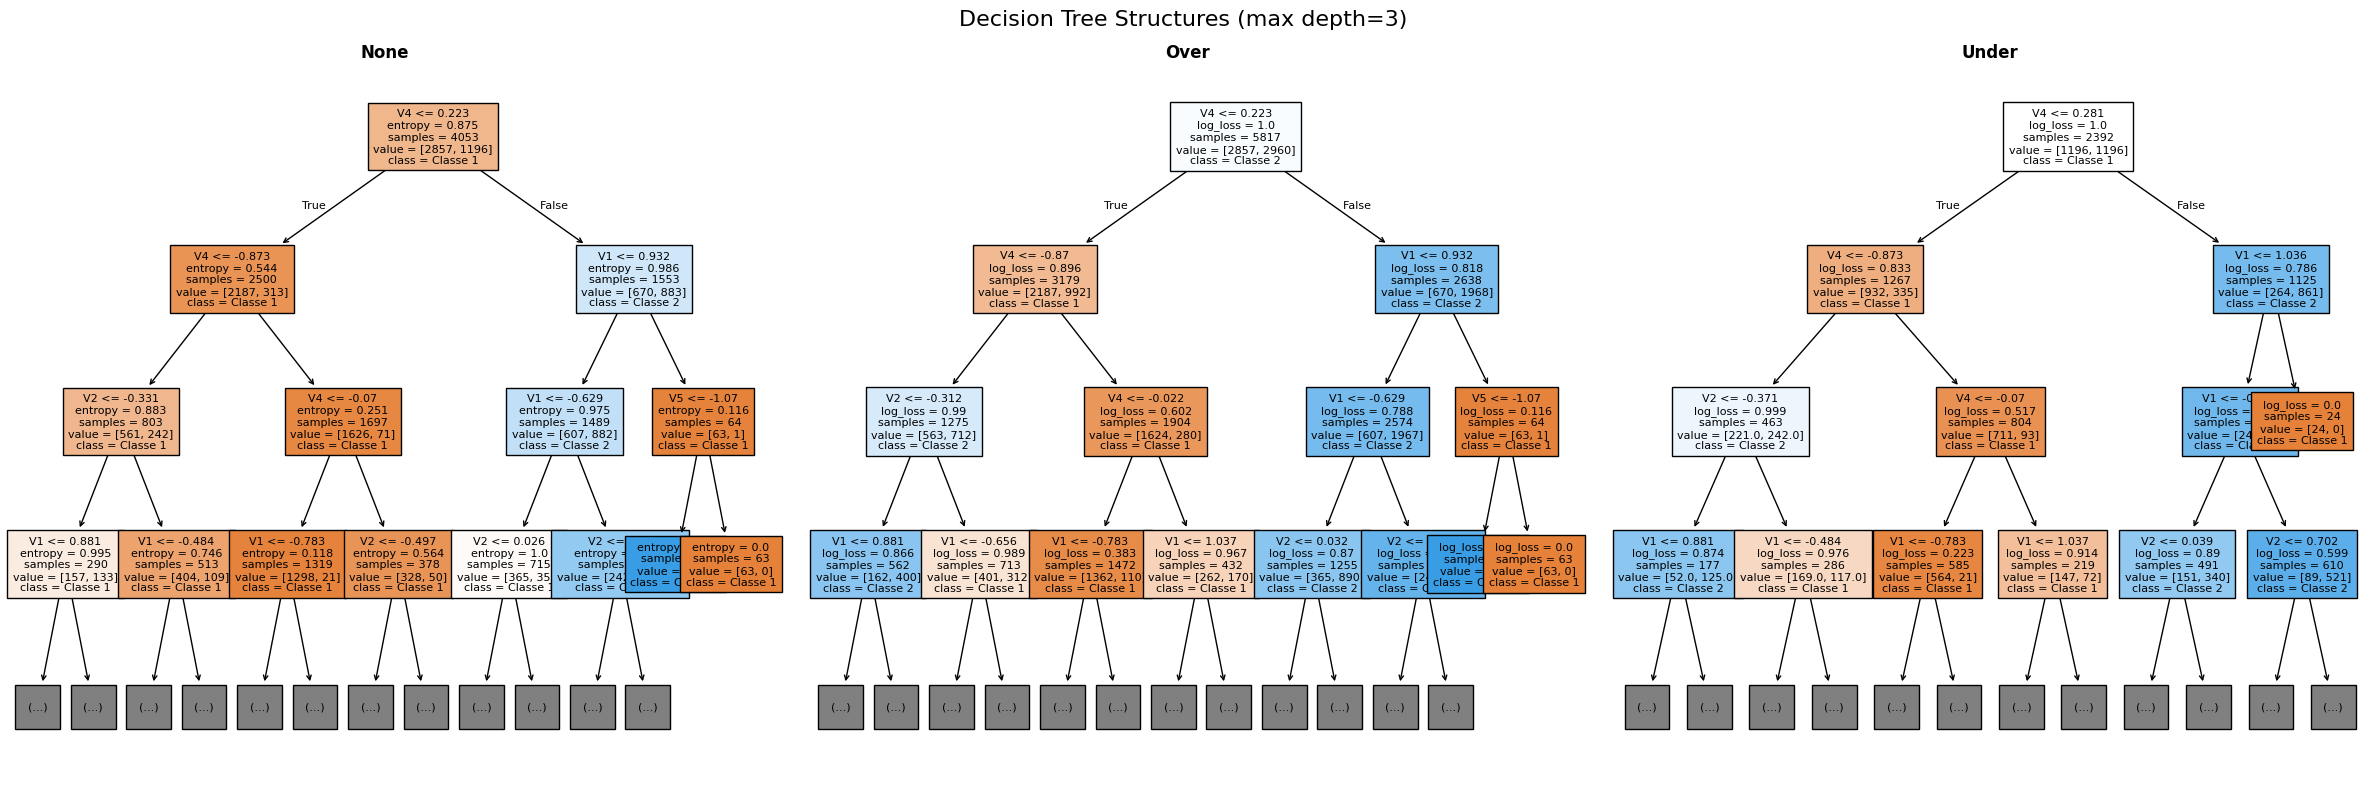


FEATURE IMPORTANCE RANKING - NONE
feature  importance
     V4    0.375981
     V1    0.216667
     V2    0.158907
     V3    0.144942
     V5    0.103502

FEATURE IMPORTANCE RANKING - OVER
feature  importance
     V4    0.363955
     V1    0.228420
     V2    0.150572
     V5    0.129523
     V3    0.127531

FEATURE IMPORTANCE RANKING - UNDER
feature  importance
     V4    0.408867
     V1    0.202886
     V2    0.158847
     V3    0.137030
     V5    0.092370


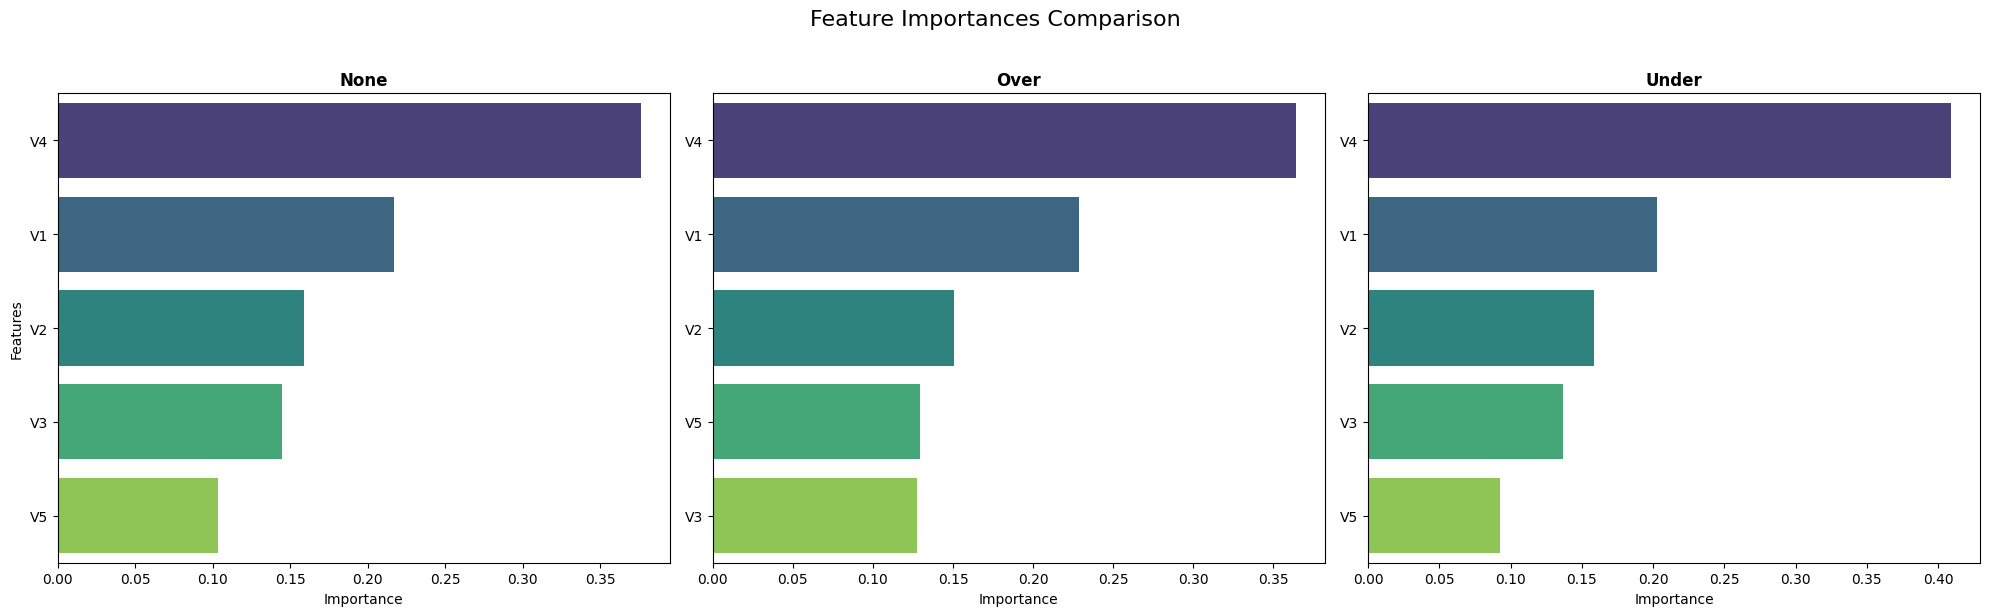

In [55]:
configs = {
    'none': (X_train, y_train),
    'over': (X_train_over, y_train_over),
    'under': (X_train_under, y_train_under)
}

colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}
roc_colors = {'none': 'blue', 'over': 'green', 'under': 'orange'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Decision Tree - Confusion Matrices Comparison', fontsize=16, y=1.02)

results = {}  
for idx, (strategy, (X_tr, y_tr)) in enumerate(configs.items()):
   
    model = models["DecisionTree"][strategy]
    model.fit(X_tr, y_tr)    
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[strategy] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred)
    }    
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap=colors[strategy], fmt="d", ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{strategy.capitalize()}\nAccuracy: {results[strategy]["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True' if idx == 0 else '')

plt.tight_layout()
plt.show()
for strategy in configs.keys():
    print(f"\n{'='*60}")
    print(f"DECISION TREE - STRATEGY: {strategy.upper()}")
    print(f"{'='*60}")
    print(f"Accuracy: {results[strategy]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, results[strategy]['y_pred']))

# visualizing ROC curves
plt.figure(figsize=(10, 7))

for strategy in configs.keys():
    y_pred_proba = results[strategy]['y_pred_proba']
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='2')
    
    plt.plot(fpr, tpr, color=roc_colors[strategy], lw=2, 
             label=f'{strategy.capitalize()} (AUC = {roc_auc:.3f})')
    
    print(f"\nROC-AUC ({strategy}): {roc_auc:.4f}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Decision Tree Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# visualizing tree structures
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Decision Tree Structures (max depth=3)', fontsize=16, y=0.98)

for idx, strategy in enumerate(configs.keys()):
    model = results[strategy]['model']
    plot_tree(model, 
              feature_names=dataset.feature_names,
              class_names=['Classe 1', 'Classe 2'],  
              filled=True, 
              max_depth=3,
              fontsize=8,
              ax=axes[idx])
    axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# visualizing feature importances with bar plots    
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importances Comparison', fontsize=16, y=1.02)

for idx, strategy in enumerate(configs.keys()):
    model = results[strategy]['model']
    
    feature_importance = pd.DataFrame({
        'feature': data.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    sns.barplot(data=feature_importance, 
                x='importance', 
                y='feature', 
                hue='feature',  
                palette='viridis',
                legend=False,
                ax=axes[idx])
    
    axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Importance", fontsize=10)
    axes[idx].set_ylabel("Features" if idx == 0 else "", fontsize=10)

    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE RANKING - {strategy.upper()}")
    print(f"{'='*60}")
    print(feature_importance.to_string(index=False))

plt.tight_layout()
plt.show()

#### 3.1.2 Naive Bayes

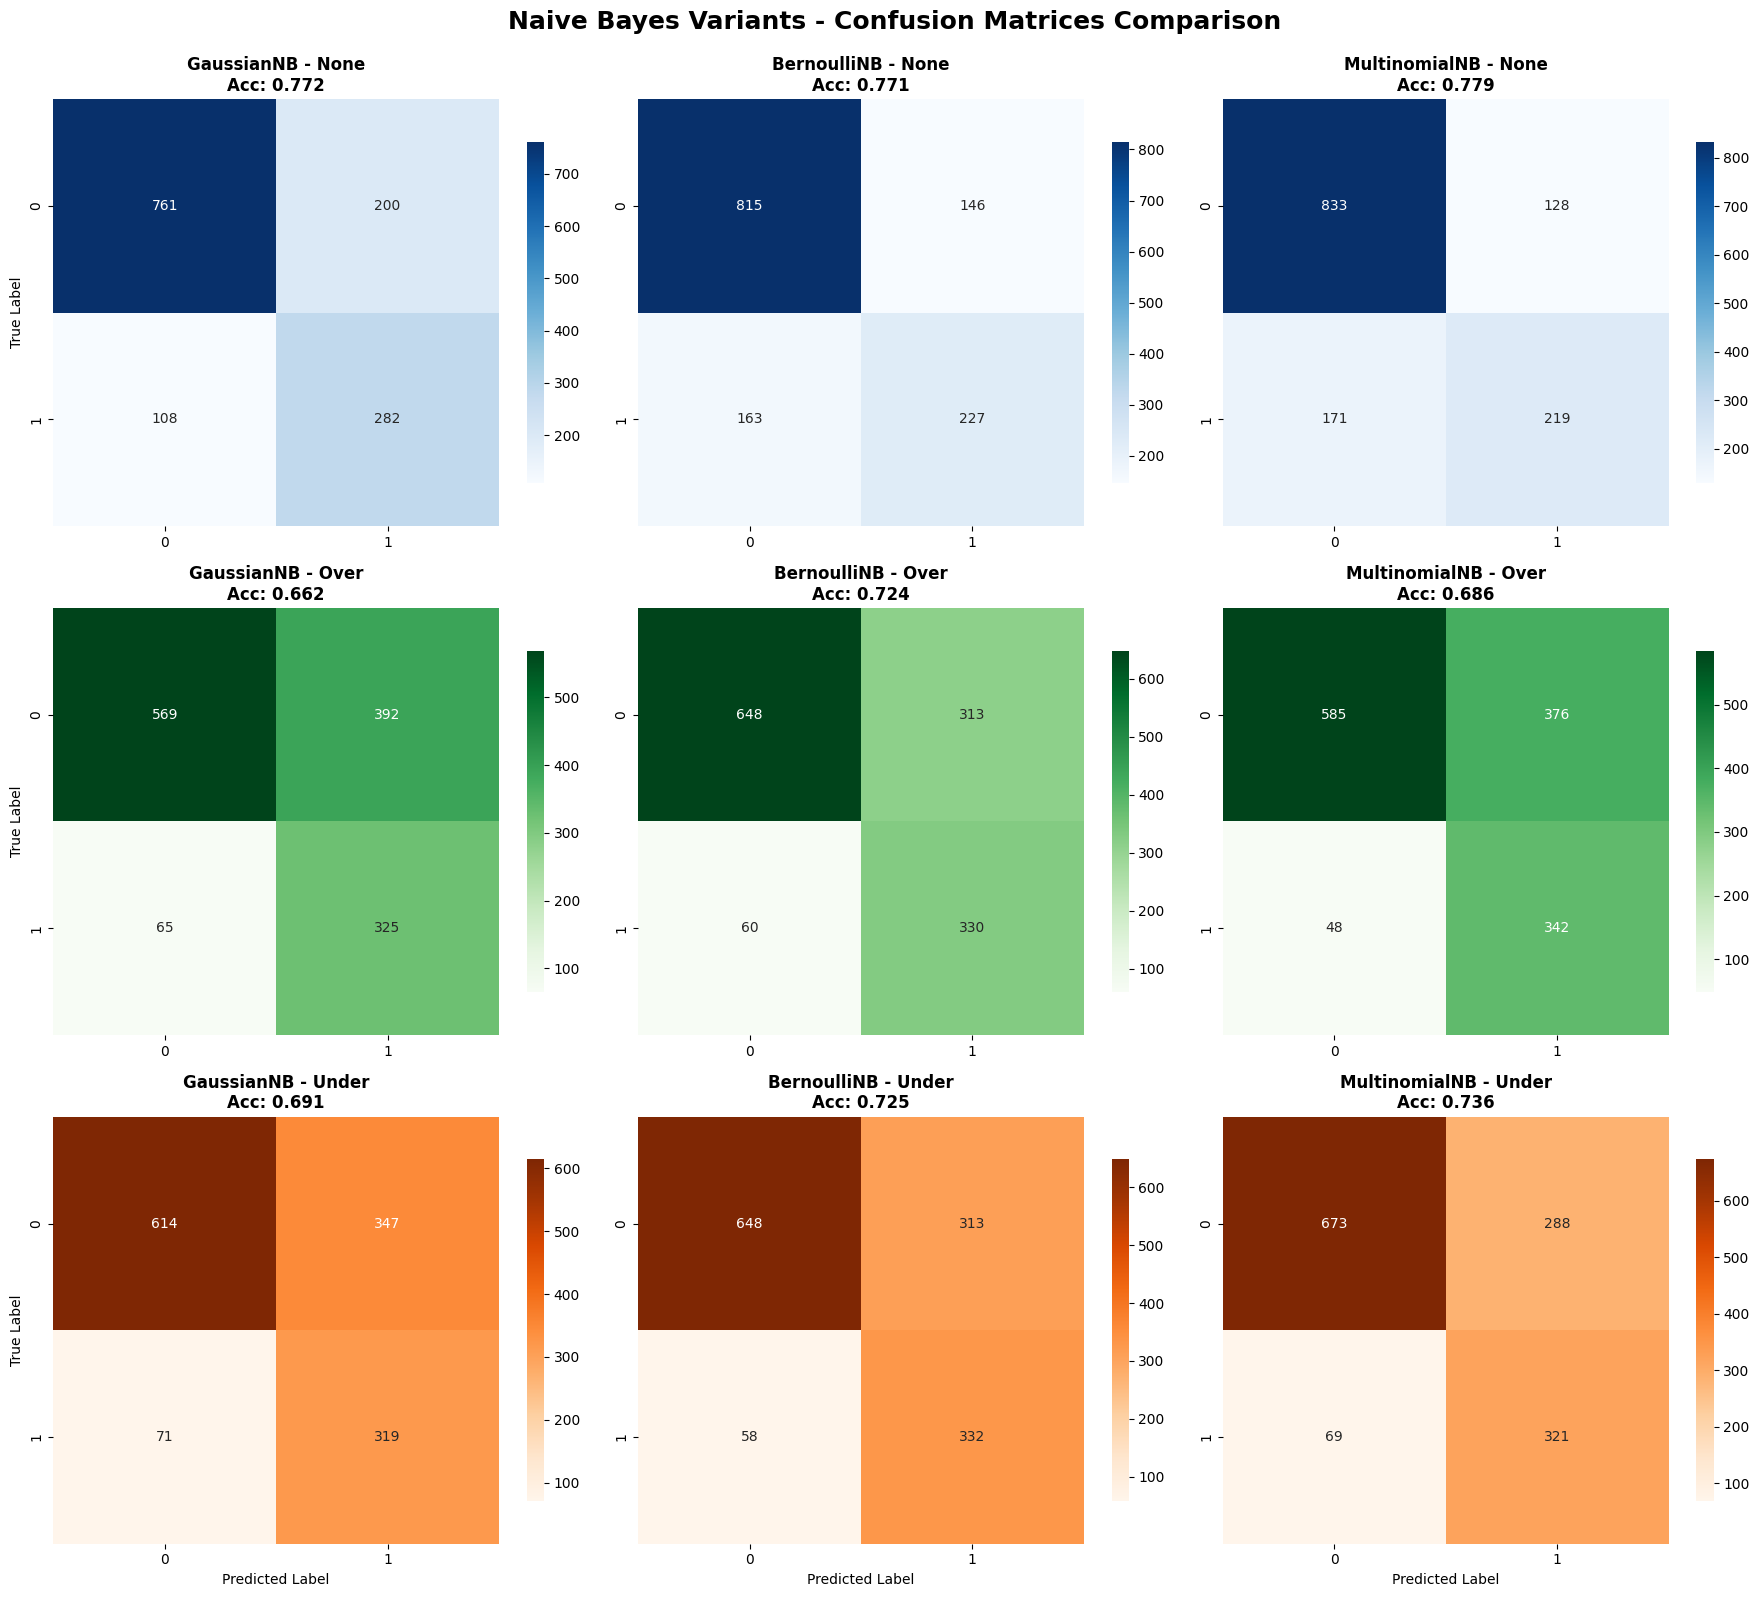

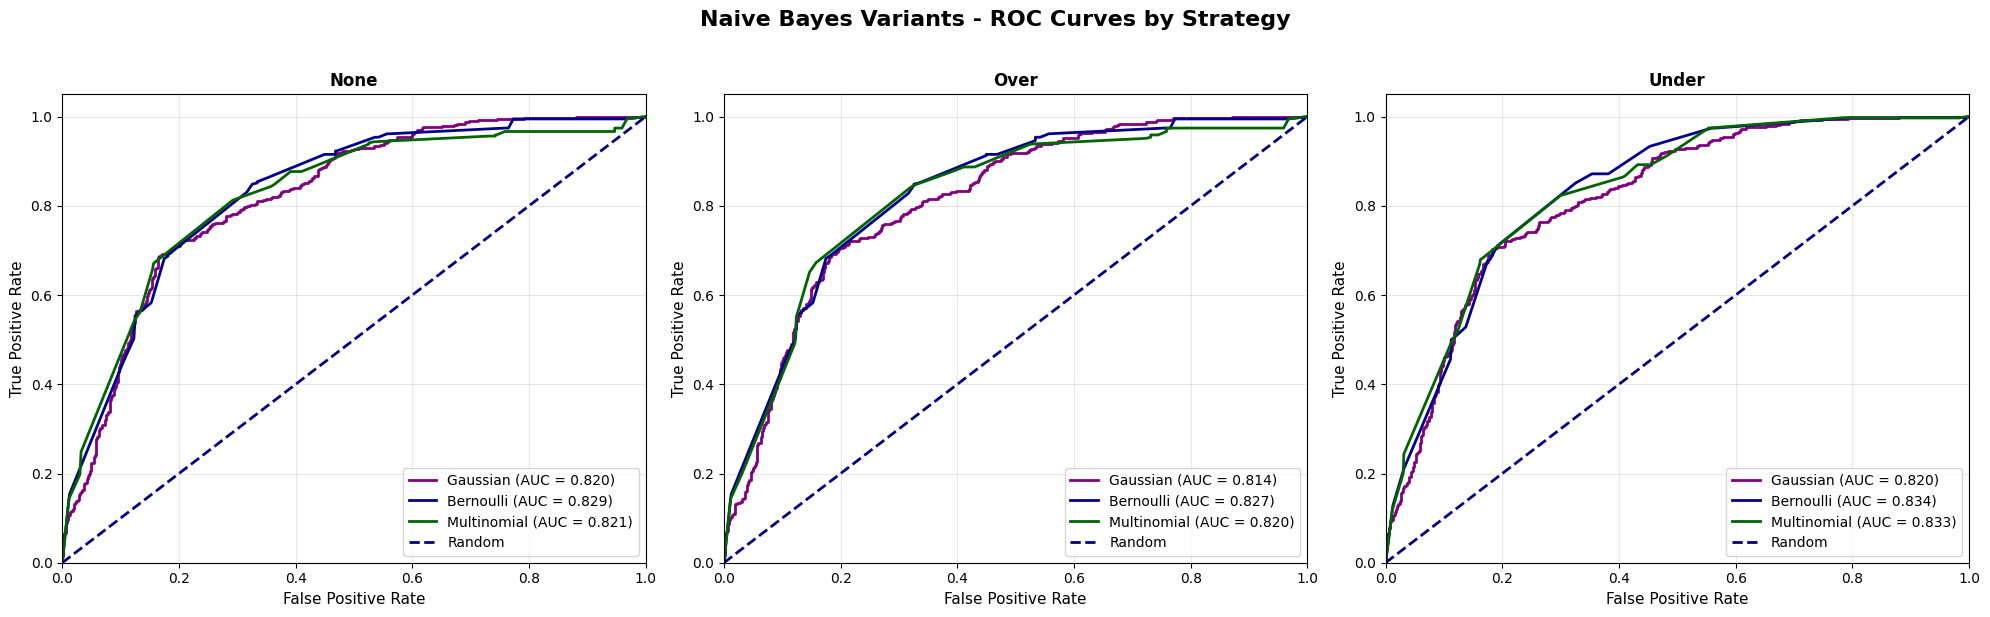

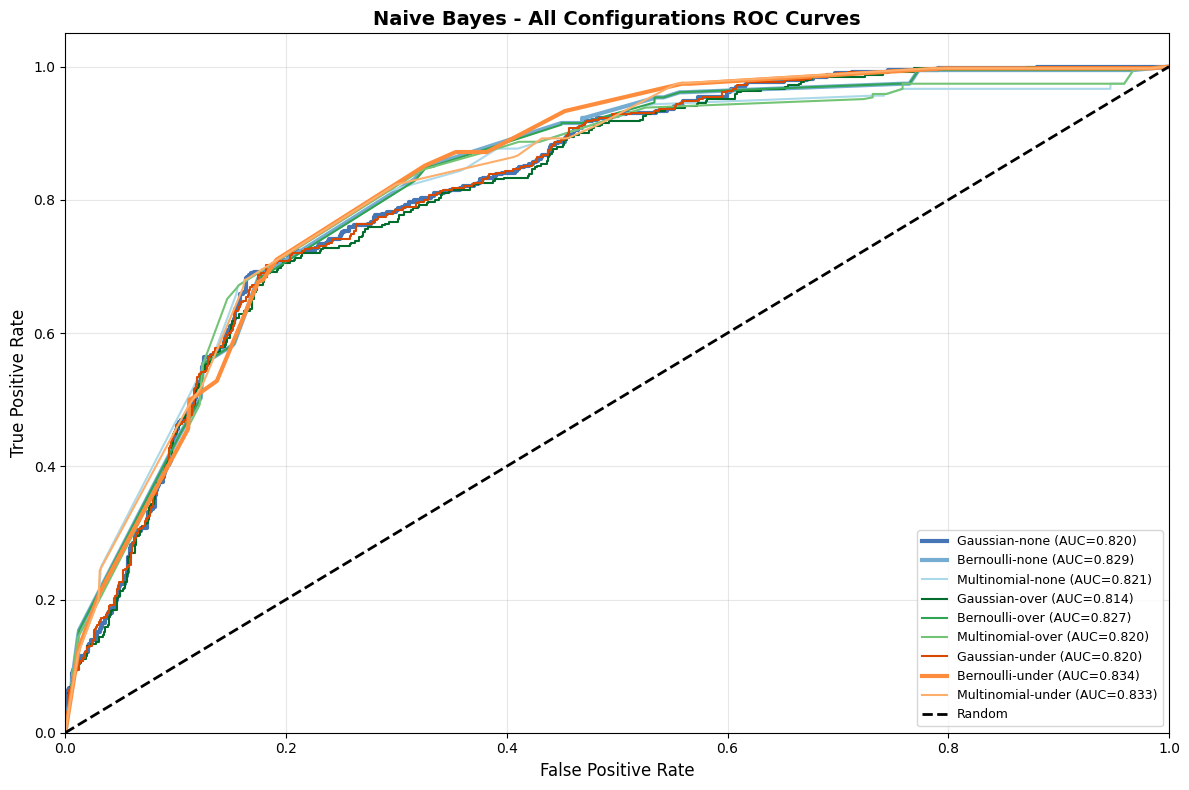


NAIVE BAYES VARIANTS - PERFORMANCE SUMMARY

STRATEGY: NONE

--- GaussianNB ---
Accuracy: 0.7720
ROC-AUC: 0.8200

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.79      0.83       961
           2       0.59      0.72      0.65       390

    accuracy                           0.77      1351
   macro avg       0.73      0.76      0.74      1351
weighted avg       0.79      0.77      0.78      1351

--------------------------------------------------------------------------------

--- BernoulliNB ---
Accuracy: 0.7713
ROC-AUC: 0.8285

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.85      0.84       961
           2       0.61      0.58      0.60       390

    accuracy                           0.77      1351
   macro avg       0.72      0.72      0.72      1351
weighted avg       0.77      0.77      0.77      1351

--------------------------------------------------

In [56]:
configs = {
    'none': (X_train, y_train, X_test),
    'over': (X_train_over, y_train_over, X_test),
    'under': (X_train_under, y_train_under, X_test)
}

nb_variants = {
    'Gaussian': GaussianNB,
    'Bernoulli': BernoulliNB,
    'Multinomial': MultinomialNB
}

scaler = MinMaxScaler()
binarizer = Binarizer(threshold=0.5)

strategy_colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}
strategy_roc_colors = {'none': 'blue', 'over': 'green', 'under': 'orange'}

all_results = {}
all_models = {}

for strategy, (X_tr, y_tr, X_te) in configs.items():
    all_results[strategy] = {}
    all_models[strategy] = {}
    
    # Preprocessing
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_te)
    X_train_binary = binarizer.fit_transform(X_train_scaled)
    X_test_binary = binarizer.transform(X_test_scaled)
    
    # GaussianNB (dati scaled)
    nb_gaussian = GaussianNB()
    nb_gaussian.fit(X_train_scaled, y_tr)
    y_pred_gaussian = nb_gaussian.predict(X_test_scaled)
    y_proba_gaussian = nb_gaussian.predict_proba(X_test_scaled)[:, 1]
    all_results[strategy]['Gaussian'] = {'pred': y_pred_gaussian, 'proba': y_proba_gaussian}
    all_models[strategy]['Gaussian'] = nb_gaussian
    
    # BernoulliNB (dati binarizzati)
    nb_bernoulli = BernoulliNB()
    nb_bernoulli.fit(X_train_binary, y_tr)
    y_pred_bernoulli = nb_bernoulli.predict(X_test_binary)
    y_proba_bernoulli = nb_bernoulli.predict_proba(X_test_binary)[:, 1]
    all_results[strategy]['Bernoulli'] = {'pred': y_pred_bernoulli, 'proba': y_proba_bernoulli}
    all_models[strategy]['Bernoulli'] = nb_bernoulli
    
    # MultinomialNB (dati binarizzati)
    nb_multinomial = MultinomialNB()
    nb_multinomial.fit(X_train_binary, y_tr)
    y_pred_multinomial = nb_multinomial.predict(X_test_binary)
    y_proba_multinomial = nb_multinomial.predict_proba(X_test_binary)[:, 1]
    all_results[strategy]['Multinomial'] = {'pred': y_pred_multinomial, 'proba': y_proba_multinomial}
    all_models[strategy]['Multinomial'] = nb_multinomial

# visualizing confusion matrices with colors per strategy
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('Naive Bayes Variants - Confusion Matrices Comparison', 
             fontsize=18, fontweight='bold', y=0.995)

for row_idx, strategy in enumerate(['none', 'over', 'under']):
    for col_idx, variant in enumerate(['Gaussian', 'Bernoulli', 'Multinomial']):
        ax = axes[row_idx, col_idx]
        
       
        y_pred = all_results[strategy][variant]['pred']
        cm = confusion_matrix(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)        
      
        sns.heatmap(cm, annot=True, cmap=strategy_colors[strategy], fmt="d", 
                   ax=ax, cbar=True, cbar_kws={'shrink': 0.8})
        
        title = f'{variant}NB - {strategy.capitalize()}\nAcc: {acc:.3f}'
        ax.set_title(title, fontsize=12, fontweight='bold')        
       
        if col_idx == 0:
            ax.set_ylabel('True Label', fontsize=10)
        else:
            ax.set_ylabel('')
        
        if row_idx == 2:
            ax.set_xlabel('Predicted Label', fontsize=10)
        else:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()

# visualizing ROC curves 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Naive Bayes Variants - ROC Curves by Strategy', 
             fontsize=16, fontweight='bold', y=1.02)

variant_roc_colors = {'Gaussian': 'purple', 'Bernoulli': 'darkblue', 'Multinomial': 'darkgreen'}

for idx, strategy in enumerate(['none', 'over', 'under']):
    ax = axes[idx]
    
    for variant in ['Gaussian', 'Bernoulli', 'Multinomial']:
        y_proba = all_results[strategy][variant]['proba']
        
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='2')
        roc_auc = roc_auc_score(y_test, y_proba)
        
        ax.plot(fpr, tpr, color=variant_roc_colors[variant], lw=2, 
                label=f'{variant} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{strategy.capitalize()}', fontweight='bold', fontsize=12)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# visualizing all ROC curves together to find the best configuration
plt.figure(figsize=(12, 8))
plt.title('Naive Bayes - All Configurations ROC Curves', 
          fontsize=14, fontweight='bold')
combo_colors = {
    ('none', 'Gaussian'): '#4575b4',      # blu scuro
    ('none', 'Bernoulli'): '#74add1',     # blu medio
    ('none', 'Multinomial'): '#abd9e9',   # blu chiaro
    ('over', 'Gaussian'): '#006d2c',      # verde scuro
    ('over', 'Bernoulli'): '#31a354',     # verde medio
    ('over', 'Multinomial'): '#74c476',   # verde chiaro
    ('under', 'Gaussian'): '#d94801',     # arancio scuro
    ('under', 'Bernoulli'): '#fd8d3c',    # arancio medio
    ('under', 'Multinomial'): '#fdae6b',  # arancio chiaro
}

best_auc = 0
best_config = None

for strategy in ['none', 'over', 'under']:
    for variant in ['Gaussian', 'Bernoulli', 'Multinomial']:
        y_proba = all_results[strategy][variant]['proba']

        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='2')
        roc_auc = roc_auc_score(y_test, y_proba)

        if roc_auc > best_auc:
            best_auc = roc_auc
            best_config = (strategy, variant)
        
        linestyle = '-'
        linewidth = 3 if (strategy == best_config[0] and variant == best_config[1]) else 1.5
        
        plt.plot(fpr, tpr, 
                color=combo_colors[(strategy, variant)], 
                lw=linewidth,
                linestyle=linestyle,
                label=f'{variant}-{strategy} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("NAIVE BAYES VARIANTS - PERFORMANCE SUMMARY")
print("="*80)

comparison_data = []

for strategy in ['none', 'over', 'under']:
    print(f"\n{'='*80}")
    print(f"STRATEGY: {strategy.upper()}")
    print(f"{'='*80}")
    
    for variant in ['Gaussian', 'Bernoulli', 'Multinomial']:
        y_pred = all_results[strategy][variant]['pred']
        y_proba = all_results[strategy][variant]['proba']
        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        comparison_data.append({
            'Strategy': strategy.capitalize(),
            'Variant': variant,
            'Accuracy': f"{acc:.4f}",
            'ROC-AUC': f"{roc_auc:.4f}"
        })
        
        print(f"\n--- {variant}NB ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("-" * 80)

print("\n" + "="*80)
print("COMPARISON TABLE - ALL CONFIGURATIONS")
print("="*80)
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("BEST CONFIGURATION")
print("="*80)
print(f"Strategy: {best_config[0].upper()}")
print(f"Variant: {best_config[1]}NB")
print(f"ROC-AUC: {best_auc:.4f}")
best_acc = accuracy_score(y_test, all_results[best_config[0]][best_config[1]]['pred'])
print(f"Accuracy: {best_acc:.4f}")
print("="*80)

#### 3.1.3 KNN Classifier

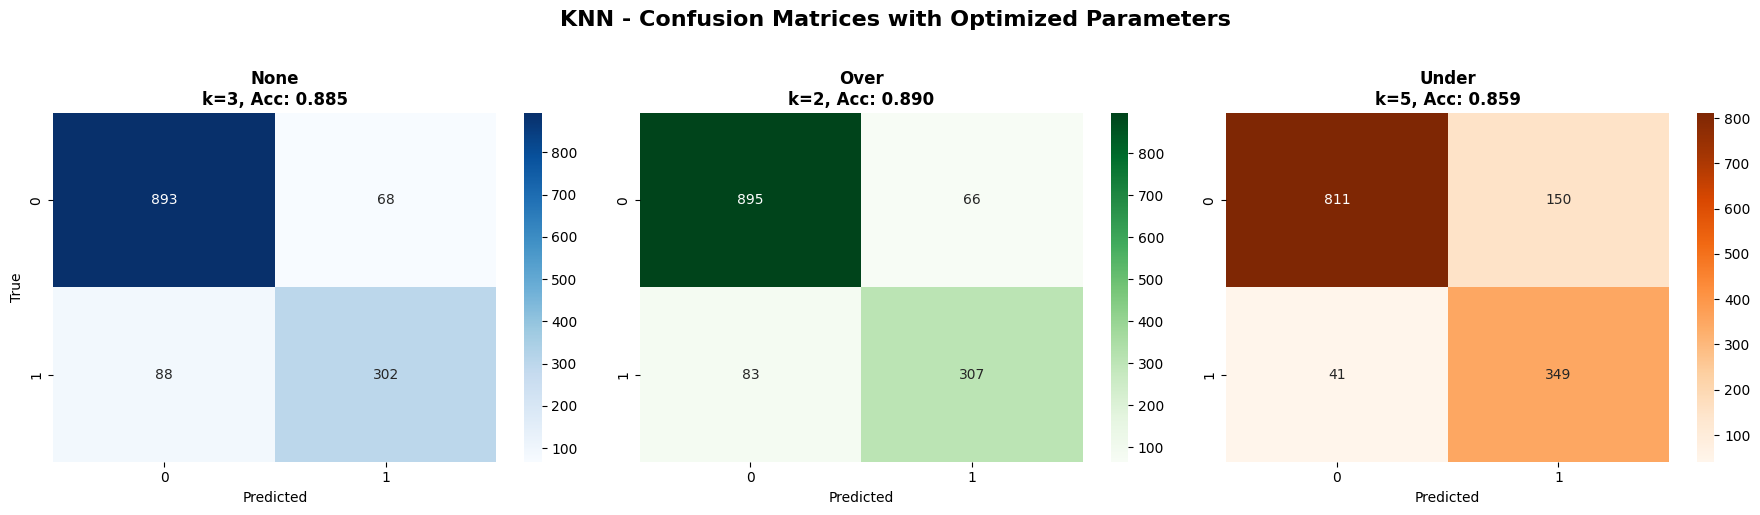

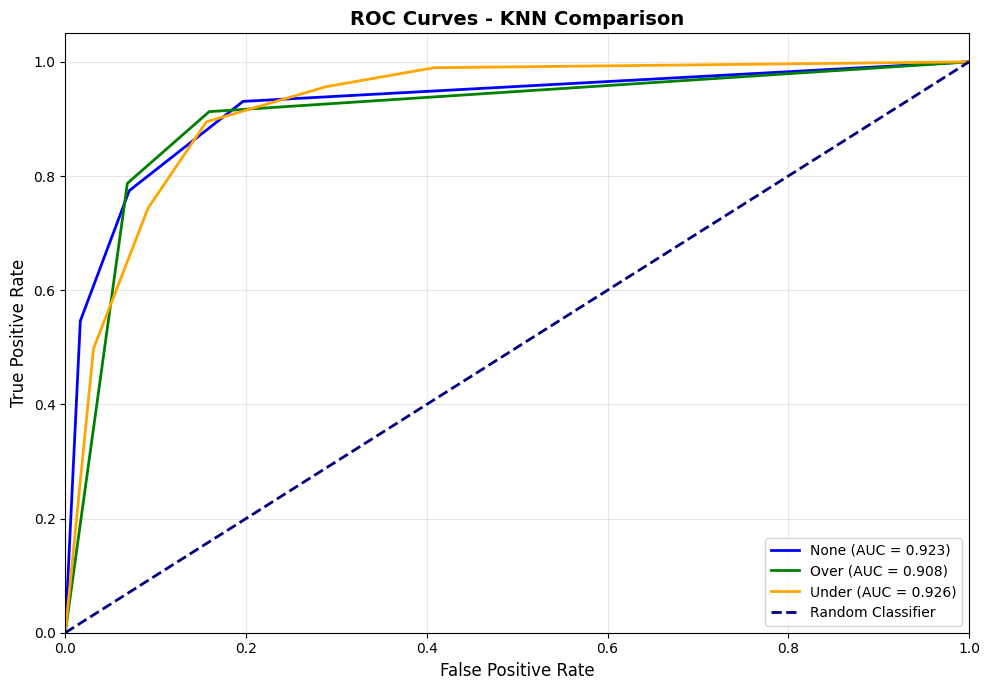


KNN - SUMMARY WITH OPTIMIZED PARAMETERS

STRATEGY: NONE
Optimal k: 3
Distance metric: minkowski
Accuracy: 0.8845
ROC-AUC: 0.9231

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.93      0.92       961
           2       0.82      0.77      0.79       390

    accuracy                           0.88      1351
   macro avg       0.86      0.85      0.86      1351
weighted avg       0.88      0.88      0.88      1351


STRATEGY: OVER
Optimal k: 2
Distance metric: minkowski
Accuracy: 0.8897
ROC-AUC: 0.9081

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.93      0.92       961
           2       0.82      0.79      0.80       390

    accuracy                           0.89      1351
   macro avg       0.87      0.86      0.86      1351
weighted avg       0.89      0.89      0.89      1351


STRATEGY: UNDER
Optimal k: 5
Distance metric: euclidean
Accuracy: 0.8586
ROC-A

In [57]:
configs = {
    'none': (X_train, y_train),
    'over': (X_train_over, y_train_over),
    'under': (X_train_under, y_train_under)
}
colors = {'none': 'blue', 'over': 'green', 'under': 'orange'}
cm_colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}

final_results = {}
scalers = {}

for strategy, (X_tr, y_tr) in configs.items():
    # Scaling 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_test)    
    
    model = models["KNN"][strategy]
    model.fit(X_train_scaled, y_tr)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # results 
    final_results[strategy] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'k': model.n_neighbors,
        'metric': model.metric
    }
    scalers[strategy] = (X_train_scaled, X_test_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('KNN - Confusion Matrices with Optimized Parameters', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, strategy in enumerate(['none', 'over', 'under']):
    model = models["KNN"][strategy]
    y_pred = final_results[strategy]['y_pred']
    acc = final_results[strategy]['accuracy']
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap=cm_colors[strategy], fmt="d", ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{strategy.capitalize()}\nk={model.n_neighbors}, Acc: {acc:.3f}', 
                       fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True' if idx == 0 else '')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

for strategy in configs.keys():
    y_pred_proba = final_results[strategy]['y_pred_proba']
    
    # Calcola ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='2')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[strategy], lw=2, 
             label=f'{strategy.capitalize()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - KNN Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("\n" + "="*80)
print("KNN - SUMMARY WITH OPTIMIZED PARAMETERS")
print("="*80)

for strategy in ['none', 'over', 'under']:
    print(f"\n{'='*80}")
    print(f"STRATEGY: {strategy.upper()}")
    print(f"{'='*80}")
    print(f"Optimal k: {final_results[strategy]['k']}")
    print(f"Distance metric: {final_results[strategy]['metric']}")
    print(f"Accuracy: {final_results[strategy]['accuracy']:.4f}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, final_results[strategy]['y_pred_proba'])
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, final_results[strategy]['y_pred']))

print("\n" + "="*80)
print("PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_data = []
for strategy in ['none', 'over', 'under']:
    roc_auc = roc_auc_score(y_test, final_results[strategy]['y_pred_proba'])
    
    summary_data.append({
        'Strategy': strategy.capitalize(),
        'k': final_results[strategy]['k'],
        'Metric': final_results[strategy]['metric'],
        'Accuracy': f"{final_results[strategy]['accuracy']:.4f}",
        'ROC-AUC': f"{roc_auc:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

#### 3.1.4 SVM Classifier

Training SVM with none sampling...
Training SVM with over sampling...
Training SVM with under sampling...


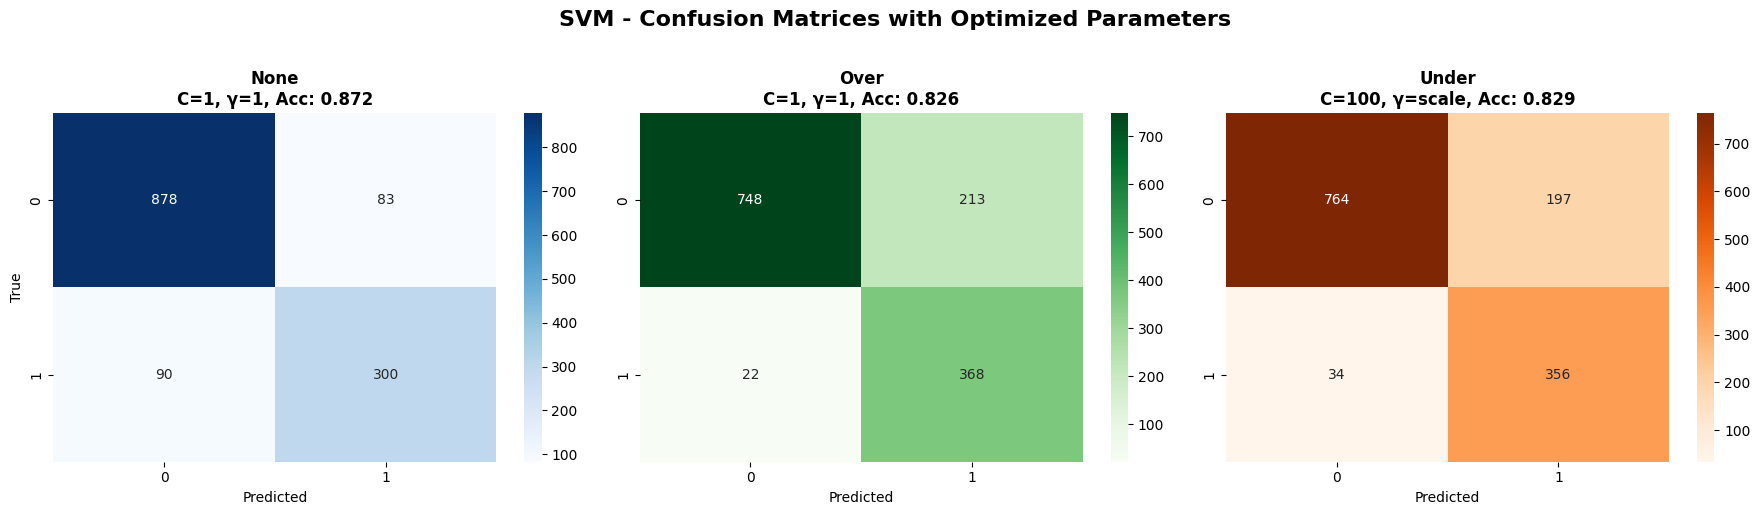

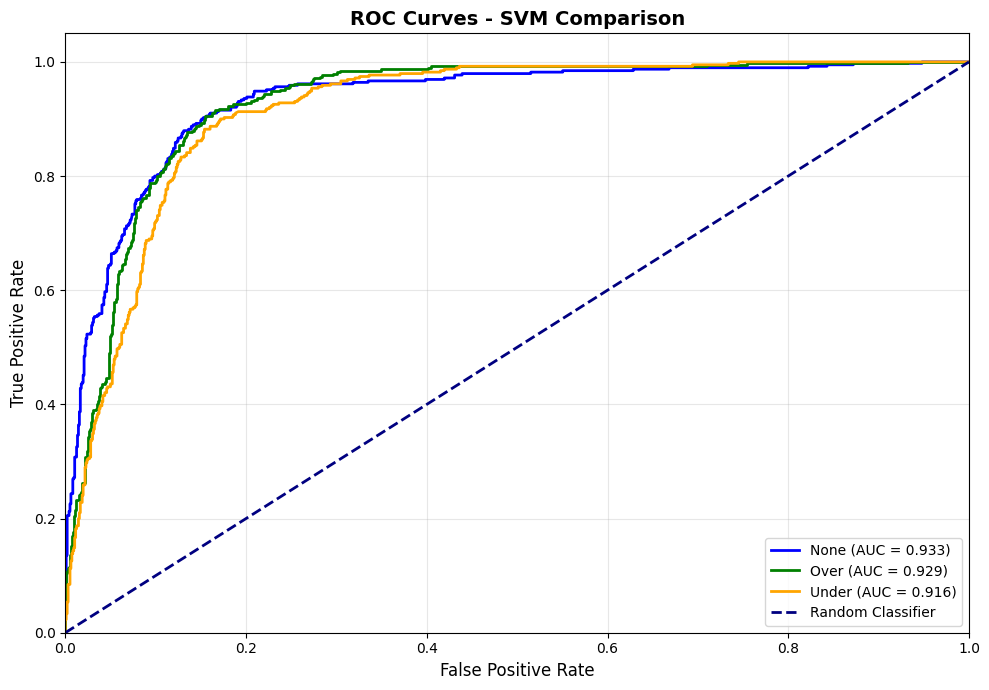

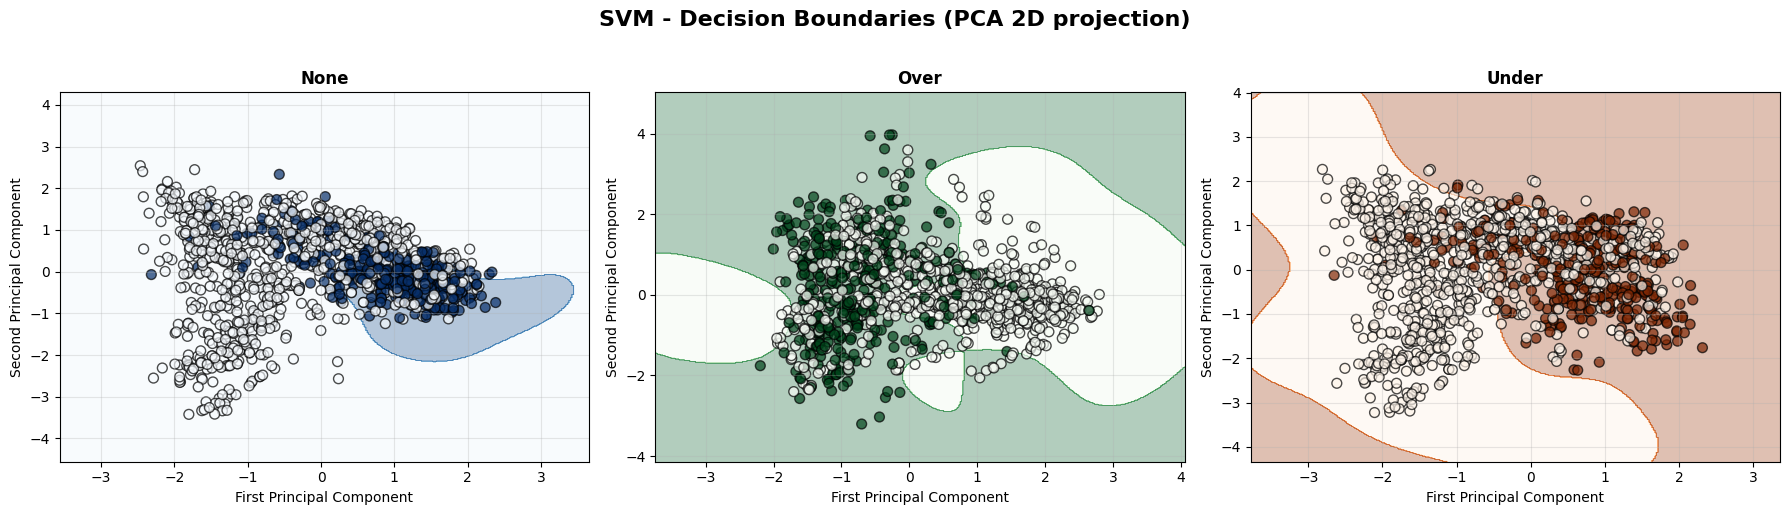


SVM - SUMMARY WITH OPTIMIZED PARAMETERS

STRATEGY: NONE
Kernel: rbf
C (regularization): 1
Gamma: 1
Accuracy: 0.8719
ROC-AUC: 0.9325

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91       961
           2       0.78      0.77      0.78       390

    accuracy                           0.87      1351
   macro avg       0.85      0.84      0.84      1351
weighted avg       0.87      0.87      0.87      1351


STRATEGY: OVER
Kernel: rbf
C (regularization): 1
Gamma: 1
Accuracy: 0.8261
ROC-AUC: 0.9293

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.78      0.86       961
           2       0.63      0.94      0.76       390

    accuracy                           0.83      1351
   macro avg       0.80      0.86      0.81      1351
weighted avg       0.87      0.83      0.83      1351


STRATEGY: UNDER
Kernel: rbf
C (regularization): 100
Gamma: scale
Accurac

In [58]:

configs = {
    'none': (X_train, y_train),
    'over': (X_train_over, y_train_over),
    'under': (X_train_under, y_train_under)
}

# Colori per ogni strategia
colors = {'none': 'blue', 'over': 'green', 'under': 'orange'}
cm_colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}

#  probability=True:
# 1. SVM calcola la decision_function (distanza dall'iperpiano di separazione)
# 2. Usa Platt Scaling: una calibrazione con cross-validation 5-fold interna
# 3. Trasforma le distanze in vere probabilità [0,1] tramite regressione logistica
#
#   decision_function: [-2.3, 0.1, 1.8]   >>> distanze dall'iperpiano
#   predict_proba:     [0.09, 0.52, 0.86]  >>> probabilità P(classe=2)

for strategy in ['none', 'over', 'under']:
    models["SVC"][strategy].set_params(probability=True)


final_results = {}
scalers = {}

for strategy, (X_tr, y_tr) in configs.items():
    print(f"Training SVM with {strategy} sampling...")
    
    # Scaling 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_test)
    model = models["SVC"][strategy]
    model.fit(X_train_scaled, y_tr)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # results
    final_results[strategy] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'C': model.C,
        'gamma': model.gamma,
        'kernel': model.kernel
    }
    scalers[strategy] = (X_train_scaled, X_test_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SVM - Confusion Matrices with Optimized Parameters', 
             fontsize=16, fontweight='bold', y=1.02)

# Plot confusion matrices
for idx, strategy in enumerate(['none', 'over', 'under']):
    model = models["SVC"][strategy]
    y_pred = final_results[strategy]['y_pred']
    acc = final_results[strategy]['accuracy']
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap=cm_colors[strategy], fmt="d", ax=axes[idx], cbar=True)
    axes[idx].set_title(f'{strategy.capitalize()}\nC={model.C}, γ={model.gamma}, Acc: {acc:.3f}', 
                       fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True' if idx == 0 else '')

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 7))
for strategy in configs.keys():
    y_pred_proba = final_results[strategy]['y_pred_proba']
    
    # Calcola ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='2')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[strategy], lw=2, 
             label=f'{strategy.capitalize()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SVM Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test_numeric = le.fit_transform(y_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SVM - Decision Boundaries (PCA 2D projection)', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, strategy in enumerate(['none', 'over', 'under']):
    ax = axes[idx]
    
    # Riduzione a 2D con PCA
    X_train_scaled, X_test_scaled = scalers[strategy]
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Converti y_train in numeri
    y_train_numeric = le.transform(configs[strategy][1])
    
    # Train SVM su dati 2D
    model_2d = SVC(C=models["SVC"][strategy].C, 
                   gamma=models["SVC"][strategy].gamma,
                   kernel=models["SVC"][strategy].kernel,
                   random_state=42)
    model_2d.fit(X_train_pca, y_train_numeric)
    
    # Crea mesh grid
    h = 0.02
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predici su mesh (restituisce valori numerici)
    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap=cm_colors[strategy])
    
    # Plot punti di test
    scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                        c=y_test_numeric, cmap=cm_colors[strategy], 
                        edgecolors='black', s=50, alpha=0.7)
    
    ax.set_title(f'{strategy.capitalize()}', fontweight='bold')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SVM - SUMMARY WITH OPTIMIZED PARAMETERS")
print("="*80)

for strategy in ['none', 'over', 'under']:
    print(f"\n{'='*80}")
    print(f"STRATEGY: {strategy.upper()}")
    print(f"{'='*80}")
    print(f"Kernel: {final_results[strategy]['kernel']}")
    print(f"C (regularization): {final_results[strategy]['C']}")
    print(f"Gamma: {final_results[strategy]['gamma']}")
    print(f"Accuracy: {final_results[strategy]['accuracy']:.4f}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, final_results[strategy]['y_pred_proba'])
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, final_results[strategy]['y_pred']))

print("\n" + "="*80)
print("SVM - PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_data = []
for strategy in ['none', 'over', 'under']:
    roc_auc = roc_auc_score(y_test, final_results[strategy]['y_pred_proba'])
    
    summary_data.append({
        'Strategy': strategy.capitalize(),
        'C': final_results[strategy]['C'],
        'Gamma': final_results[strategy]['gamma'],
        'Kernel': final_results[strategy]['kernel'],
        'Accuracy': f"{final_results[strategy]['accuracy']:.4f}",
        'ROC-AUC': f"{roc_auc:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("SUPPORT VECTORS INFORMATION")
print("="*80)

for strategy in ['none', 'over', 'under']:
    model = models["SVC"][strategy]
    n_support = model.n_support_
    print(f"\n{strategy.upper()}:")
    print(f"  Total support vectors: {sum(n_support)}")
    print(f"  Support vectors per class: {n_support}")
    print(f"  Percentage of training data: {sum(n_support) / len(configs[strategy][1]) * 100:.2f}%")

print("="*80)

### 3.2 Ensemble Classifiers Machine Learning 

#### 3.2.2 AdaBoost

#### 3.2.3 Extreme Gradient Boosting

#### 3.2.4 Custom Ensemble

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

## 4. Evaluation

## 5. Result Discussion